In [10]:
## This Cell is related to date preprocessing and is completely copied from original kipf's github code!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch,torch.nn,torch.sparse,torch.nn.functional,torch.distributions
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.inf)


from google.colab import drive
drive.mount('/content/drive')


W_gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/gene.txt", delim_whitespace=True).to_numpy()
W_methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/methy.txt", delim_whitespace=True).to_numpy()
W_mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/mirna.txt", delim_whitespace=True).to_numpy()
W_fused     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/W_fused.txt", delim_whitespace=True).to_numpy()

W_gene  =  np.array(ro.r['W_gene'])
W_methy =  np.array(ro.r['W_methy'])
W_mirna =  np.array(ro.r['W_mirna'])

gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", delim_whitespace=True).to_numpy().transpose()
methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", delim_whitespace=True).to_numpy().transpose()
mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", delim_whitespace=True).to_numpy().transpose()
truelabel =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", delim_whitespace=True).to_numpy()



print(gene.shape)
print(methy.shape)
print(mirna.shape)

def get_nomralized_laplacian(a):
    no = a.shape[0]
    b = np.diag(np.power(1.0 / a.sum(axis=1), 0.5))
    res = (b @ a @ b)
    #res[range(a.shape[0]),range(a.shape[0])]*=3
    return res




%load_ext rpy2.ipython





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


(215, 12042)
(215, 1305)
(215, 534)
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [0]:
#Model definition Cell


cluster_num = 5
emb_dim = 10



class Model(torch.nn.Module):

    def __init__(self,optimizer_type,A_tilda_gene,A_tilda_methy,A_tilda_mirna,**kwargs):
        super(Model, self).__init__(**kwargs)
        
        
        

        self.L_layer = torch.nn.Linear(cluster_num,215,bias=False)
        self.dropout_layer_1 = torch.nn.Dropout(p=0)
        self.dropout_layer_2 = torch.nn.Dropout(p=0)

        ###########################

        
            

        self.W0 = torch.nn.Linear(215,emb_dim)
        self.W1 = torch.nn.Linear(emb_dim,215)
       
        self.attn_gene = torch.nn.Linear(215,1)
        self.attn_methy = torch.nn.Linear(215,1)
        self.attn_mirna = torch.nn.Linear(215,1)
        
        param_list = []
        param_list += list(self.W0.parameters())
        param_list += list(self.W1.parameters())
        param_list += list(self.attn_gene.parameters())
        param_list += list(self.attn_methy.parameters())
        param_list += list(self.attn_mirna.parameters())
        param_list += list(self.L_layer.parameters())
        
        self.A_tilda_gene = A_tilda_gene
        self.A_tilda_methy = A_tilda_methy
        self.A_tilda_mirna = A_tilda_mirna

        
        if optimizer_type == 'adam':
          self.optimizer = torch.optim.Adam(param_list,lr=0.01)
        elif optimizer_type=='lbfgs':
          self.optimizer = torch.optim.LBFGS(param_list,lr=0.01,max_iter=20)
        self.recon = None
        
        self.normal_dist = torch.distributions.MultivariateNormal(loc=torch.zeros(emb_dim),scale_tril=torch.eye(emb_dim))
        #torch.distributions.Trun
        
        
        
    


        
    def forward(self,x) : 
        
        self.g_prim_gene =  self.attn_gene(self.A_tilda_gene).view(-1,1)
        self.g_prim_methy =  self.attn_methy(self.A_tilda_methy).view(-1,1)
        self.g_prim_mirna =  self.attn_mirna(self.A_tilda_mirna).view(-1,1)
        self.g_prim = torch.cat([self.g_prim_gene,self.g_prim_methy,self.g_prim_mirna],1)
        self.g = torch.nn.functional.softmax(self.g_prim,dim=1)
        self.g_gene = self.g[:,0].view(-1)
        self.g_methy = self.g[:,1].view(-1)
        self.g_mirna = self.g[:,2].view(-1)

         
        self.view_hat  = torch.diag(self.g_gene) @ self.A_tilda_gene @ torch.diag(self.g_gene)  +  torch.diag(self.g_methy) @ self.A_tilda_methy @ torch.diag(self.g_methy)   +    torch.diag(self.g_mirna) @ self.A_tilda_mirna @ torch.diag(self.g_mirna)
        #self.view_hat  =  self.A_tilda_gene

        #self.A_tilda_hat = 0.1 * torch.Tensor(np.identity(215)) + self.view_hat
        #self.A_tilda_hat = 1 * torch.Tensor(np.identity(215))*self.view_hat +1* self.view_hat
        self.A_tilda_hat = 0*torch.Tensor(np.identity(215)) +1* self.view_hat



        
        
       
        #self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))+ 0.001 * self.normal_dist.sample((x.shape[0],))
        self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))
        #self.layer_1 = torch.nn.functional.softmax(self.A_tilda_hat @ self.W0(x),1)

        self.layer_1 =  self.dropout_layer_1(self.layer_1)
        
        self.layer_2 = torch.nn.functional.softmax(self.A_tilda_hat @ self.W1(self.layer_1),1)
        #self.layer_2 = torch.nn.functional.relu(self.A_tilda_hat @ self.W1(self.layer_1))
        
        self.layer_2 = self.dropout_layer_2(self.layer_2)

        self.x_prim = self.layer_2
        self.embedding = self.layer_1
        
        self.recon_loss = torch.nn.functional.cross_entropy(self.x_prim, target=torch.nonzero(x)[:,1],reduction='mean')
        #self.recon_loss = (torch.abs(self.x_prim-x)).mean()
        #self.recon_loss = (torch.abs(self.x_prim-x)**2).mean()
        self.fair_attention_loss = self.g_gene.mean()*torch.log(self.g_gene.mean()) + self.g_methy.mean()*torch.log(self.g_methy.mean()) + self.g_mirna.mean()*torch.log(self.g_mirna.mean()) 
        self.L = self.L_layer(torch.Tensor(np.identity(cluster_num)))
        self.clustering_loss = torch.trace( self.L @ self.A_tilda_hat @ self.L.transpose(0,1) )
        self.ortho_L_loss = self.L @ self.L.transpose(0,1) - torch.Tensor(np.identity(cluster_num)) 
        #self.ortho_L_loss = (self.ortho_L_loss**2).mean()
        self.ortho_L_loss = (torch.abs(self.ortho_L_loss)).mean()
        
        self.L1_on_view_hat  = torch.abs(self.view_hat).mean()
        self.L1_on_layer_1 = torch.abs(self.W0.weight).mean()
        #self.L2_on_layer_2 = torch.abs(self.W1.weight).mean()
        
        #self.loss = self.recon_loss + 0.001 * self.fair_attention_loss + 0.1 * self.ortho_L_loss + 0.1* self.clustering_loss + 0.01*(self.layer_1**2).mean(1).mean(0)
        
        #self.loss = self.recon_loss + 0.01* self.fair_attention_loss+ 0.001*(self.layer_1**2).mean()+1*self.L1_on_view_hat
        
        self.loss = self.recon_loss + 0.01* self.fair_attention_loss+ 0.001* self.L1_on_layer_1+0.001*(self.layer_1**2).mean()+0.01*self.L1_on_view_hat
        #self.loss = self.recon_loss + 0.01* self.fair_attention_loss+0.01*self.L1_on_view_hat

        #self.loss = self.recon_loss + 0.01* self.fair_attention_loss
        #self.loss = self.recon_loss +  0.001*(self.layer_1**2).mean(1).mean(0)
        #self.loss = self.L.data.sum()
        #self.l1_regularization =  (torch.norm(list(self.W0.parameters())[0],1))+(torch.norm(list(self.W1.parameters())[0],1))
        #self.KL_loss = (self.embedding**2).mean(1).mean(0)
        #self.loss = self.recon_loss+self.KL_loss/50+self.l1_regularization/1000000
       
        
        
        
        
        
        return self.loss.item(),self.recon_loss.item(),self.fair_attention_loss.item(),self.ortho_L_loss.item(),self.clustering_loss,self.L1_on_view_hat,self.L1_on_layer_1
        
    def backprop(self) :
        
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        
    def backprop2(self,x):
      def closure():
        self.optimizer.zero_grad()
        self.forward(x)
        self.loss.backward()
        return self.loss
      self.optimizer.step(closure)    
    
      


Epoch: 0001 train_loss= 5.35969 recon_loss= 5.37064 fair_attention_loss= -1.09847 ortho_L_loss= 3.55456 clustering_loss= 2.45766 L1_on_view_hat= 0.00145 L1_on_layer_1= 0.02932


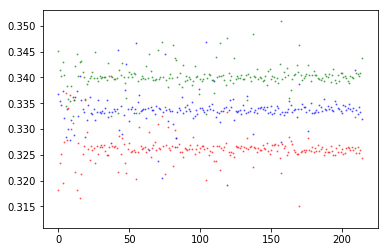

group_sc_A_tilda
 1  2  3 
90 55 70 


   pvalue 
0.8750446 


@@@@@@


group_sc_emb
  1   2   3 
 22  92 101 


   pvalue 
0.1299469 


@@@@@@@@@@@@
###############################################
Epoch: 0101 train_loss= 5.35764 recon_loss= 5.36840 fair_attention_loss= -1.08263 ortho_L_loss= 3.55456 clustering_loss= 3.81509 L1_on_view_hat= 0.00150 L1_on_layer_1= 0.00608


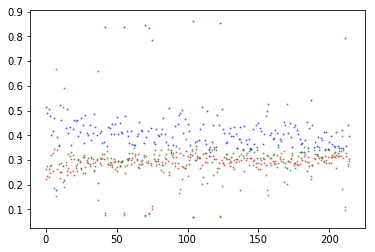

group_sc_A_tilda
 1  2  3 
68 56 91 


   pvalue 
0.8675171 


@@@@@@


group_sc_emb
  1   2   3 
106 100   9 


    pvalue 
0.01636277 


@@@@@@@@@@@@
###############################################
Epoch: 0201 train_loss= 5.34396 recon_loss= 5.35480 fair_attention_loss= -1.09837 ortho_L_loss= 3.55456 clustering_loss= 5.89138 L1_on_view_hat= 0.00147 L1_on_layer_1= 0.06977


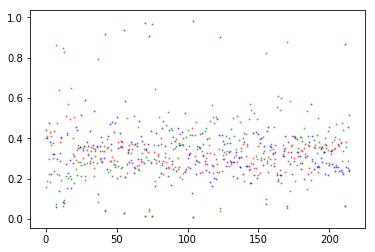

group_sc_A_tilda
 1  2  3 
80 77 58 


   pvalue 
0.9236559 


@@@@@@


group_sc_emb
  1   2   3 
  3   8 204 


   pvalue 
0.9517198 


@@@@@@@@@@@@
###############################################
Epoch: 0301 train_loss= 5.32958 recon_loss= 5.34022 fair_attention_loss= -1.09806 ortho_L_loss= 3.55456 clustering_loss= 8.00492 L1_on_view_hat= 0.00153 L1_on_layer_1= 0.20229


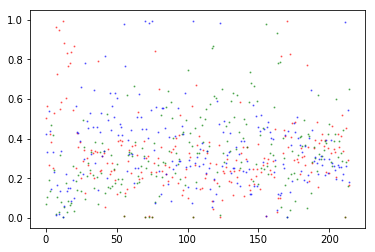

group_sc_A_tilda
 1  2  3 
89 58 68 


   pvalue 
0.5280605 


@@@@@@


group_sc_emb
  1   2   3 
  4 209   2 


   pvalue 
0.1453998 


@@@@@@@@@@@@
###############################################
Epoch: 0401 train_loss= 5.31698 recon_loss= 5.32744 fair_attention_loss= -1.09851 ortho_L_loss= 3.55456 clustering_loss= 9.32850 L1_on_view_hat= 0.00160 L1_on_layer_1= 0.29041


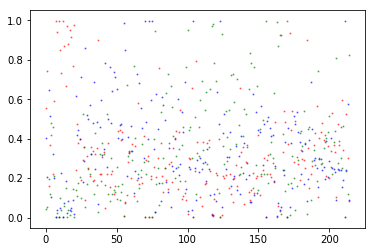

group_sc_A_tilda
 1  2  3 
88 69 58 


   pvalue 
0.7873053 


@@@@@@


group_sc_emb
  1   2   3 
  3 207   5 


   pvalue 
0.2973556 


@@@@@@@@@@@@
###############################################
Epoch: 0501 train_loss= 5.30386 recon_loss= 5.31411 fair_attention_loss= -1.09822 ortho_L_loss= 3.55456 clustering_loss= 10.36974 L1_on_view_hat= 0.00165 L1_on_layer_1= 0.30658


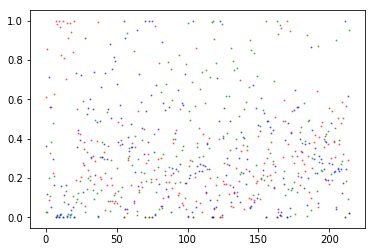

group_sc_A_tilda
 1  2  3 
83 63 69 


   pvalue 
0.5521441 


@@@@@@


group_sc_emb
  1   2   3 
203   9   3 


   pvalue 
0.3016413 


@@@@@@@@@@@@
###############################################
Epoch: 0601 train_loss= 5.29293 recon_loss= 5.30293 fair_attention_loss= -1.09836 ortho_L_loss= 3.55456 clustering_loss= 11.18017 L1_on_view_hat= 0.00169 L1_on_layer_1= 0.31558


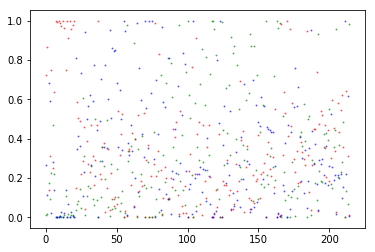

group_sc_A_tilda
 1  2  3 
87 64 64 


   pvalue 
0.8597558 


@@@@@@


group_sc_emb
  1   2   3 
  5   9 201 


   pvalue 
0.5465757 


@@@@@@@@@@@@
###############################################
Epoch: 0701 train_loss= 5.27893 recon_loss= 5.28856 fair_attention_loss= -1.09733 ortho_L_loss= 3.55456 clustering_loss= 12.10820 L1_on_view_hat= 0.00174 L1_on_layer_1= 0.35323


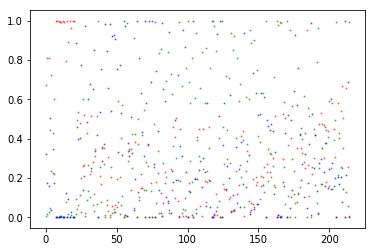

group_sc_A_tilda
 1  2  3 
80 73 62 


   pvalue 
0.6070658 


@@@@@@


group_sc_emb
  1   2   3 
199  10   6 


   pvalue 
0.6081896 


@@@@@@@@@@@@
###############################################
Epoch: 0801 train_loss= 5.26582 recon_loss= 5.27501 fair_attention_loss= -1.09812 ortho_L_loss= 3.55456 clustering_loss= 12.54872 L1_on_view_hat= 0.00175 L1_on_layer_1= 0.40169


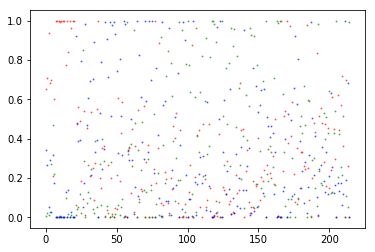

group_sc_A_tilda
 1  2  3 
85 68 62 


   pvalue 
0.2756718 


@@@@@@


group_sc_emb
  1   2   3 
196  13   6 


   pvalue 
0.7134654 


@@@@@@@@@@@@
###############################################
Epoch: 0901 train_loss= 5.25621 recon_loss= 5.26498 fair_attention_loss= -1.09847 ortho_L_loss= 3.55456 clustering_loss= 12.85268 L1_on_view_hat= 0.00177 L1_on_layer_1= 0.45499


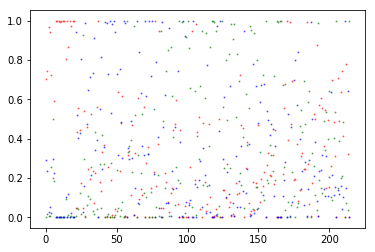

group_sc_A_tilda
 1  2  3 
88 70 57 


  pvalue 
0.285292 


@@@@@@


group_sc_emb
  1   2   3 
  8  13 194 


   pvalue 
0.5315421 


@@@@@@@@@@@@
###############################################
Epoch: 1001 train_loss= 5.24618 recon_loss= 5.25447 fair_attention_loss= -1.09843 ortho_L_loss= 3.55456 clustering_loss= 13.09744 L1_on_view_hat= 0.00180 L1_on_layer_1= 0.52445


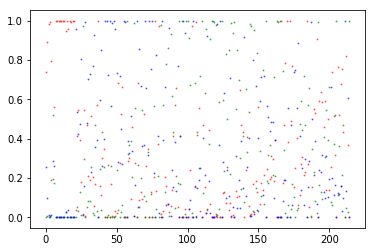

group_sc_A_tilda
 1  2  3 
63 83 69 


   pvalue 
0.9231029 


@@@@@@


group_sc_emb
  1   2   3 
188   7  20 


  pvalue 
0.843822 


@@@@@@@@@@@@
###############################################
Epoch: 1101 train_loss= 5.23740 recon_loss= 5.24520 fair_attention_loss= -1.09823 ortho_L_loss= 3.55456 clustering_loss= 13.38932 L1_on_view_hat= 0.00182 L1_on_layer_1= 0.59771


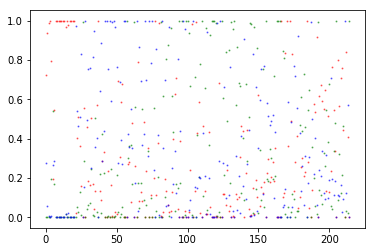

group_sc_A_tilda
 1  2  3 
87 60 68 


   pvalue 
0.5871496 


@@@@@@


group_sc_emb
  1   2   3 
 17 186  12 


   pvalue 
0.4381813 


@@@@@@@@@@@@
###############################################
Epoch: 1201 train_loss= 5.22852 recon_loss= 5.23579 fair_attention_loss= -1.09786 ortho_L_loss= 3.55456 clustering_loss= 13.50797 L1_on_view_hat= 0.00183 L1_on_layer_1= 0.67587


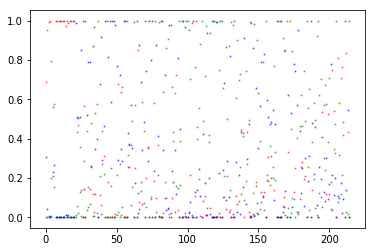

group_sc_A_tilda
 1  2  3 
69 77 69 


   pvalue 
0.7763547 


@@@@@@


group_sc_emb
  1   2   3 
186  13  16 


   pvalue 
0.2990645 


@@@@@@@@@@@@
###############################################
Epoch: 1301 train_loss= 5.21951 recon_loss= 5.22621 fair_attention_loss= -1.09703 ortho_L_loss= 3.55456 clustering_loss= 13.72213 L1_on_view_hat= 0.00185 L1_on_layer_1= 0.75369


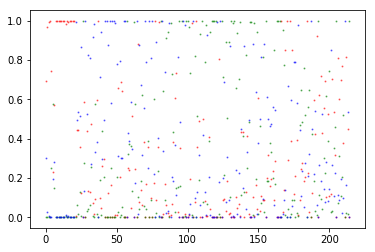

group_sc_A_tilda
 1  2  3 
72 71 72 


   pvalue 
0.7312964 


@@@@@@


group_sc_emb
  1   2   3 
190  11  14 


   pvalue 
0.6644795 


@@@@@@@@@@@@
###############################################
Epoch: 1401 train_loss= 5.20883 recon_loss= 5.21489 fair_attention_loss= -1.09737 ortho_L_loss= 3.55456 clustering_loss= 13.84976 L1_on_view_hat= 0.00186 L1_on_layer_1= 0.83287


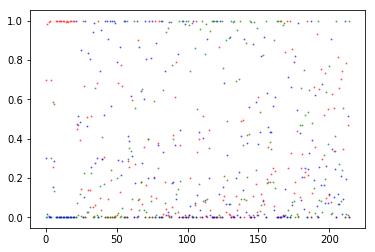

group_sc_A_tilda
 1  2  3 
59 73 83 


   pvalue 
0.7538281 


@@@@@@


group_sc_emb
  1   2   3 
189  12  14 


   pvalue 
0.6690352 


@@@@@@@@@@@@
###############################################
Epoch: 1501 train_loss= 5.20111 recon_loss= 5.20656 fair_attention_loss= -1.09784 ortho_L_loss= 3.55456 clustering_loss= 13.91152 L1_on_view_hat= 0.00187 L1_on_layer_1= 0.90153


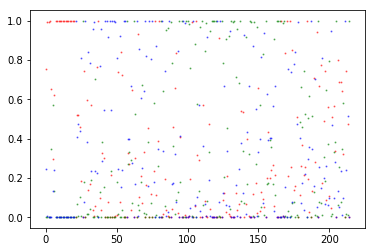

group_sc_A_tilda
 1  2  3 
61 85 69 


   pvalue 
0.6680171 


@@@@@@


group_sc_emb
  1   2   3 
188  12  15 


   pvalue 
0.4306257 


@@@@@@@@@@@@
###############################################
Epoch: 1601 train_loss= 5.19304 recon_loss= 5.19782 fair_attention_loss= -1.09792 ortho_L_loss= 3.55456 clustering_loss= 14.20732 L1_on_view_hat= 0.00189 L1_on_layer_1= 0.96951


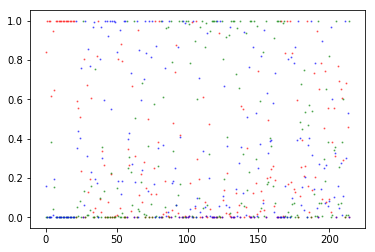

group_sc_A_tilda
 1  2  3 
72 67 76 


   pvalue 
0.3636571 


@@@@@@


group_sc_emb
  1   2   3 
 14  17 184 


   pvalue 
0.4526997 


@@@@@@@@@@@@
###############################################
Epoch: 1701 train_loss= 5.18559 recon_loss= 5.18969 fair_attention_loss= -1.09773 ortho_L_loss= 3.55456 clustering_loss= 14.32104 L1_on_view_hat= 0.00191 L1_on_layer_1= 1.04143


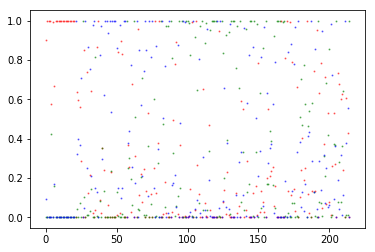

group_sc_A_tilda
 1  2  3 
74 69 72 


   pvalue 
0.4385773 


@@@@@@


group_sc_emb
  1   2   3 
184  14  17 


   pvalue 
0.4526997 


@@@@@@@@@@@@
###############################################
Epoch: 1801 train_loss= 5.17953 recon_loss= 5.18303 fair_attention_loss= -1.09806 ortho_L_loss= 3.55456 clustering_loss= 14.40279 L1_on_view_hat= 0.00191 L1_on_layer_1= 1.10141


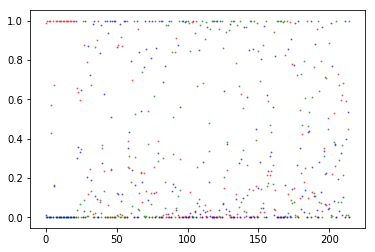

group_sc_A_tilda
 1  2  3 
78 66 71 


   pvalue 
0.2021077 


@@@@@@


group_sc_emb
  1   2   3 
182  15  18 


  pvalue 
0.904771 


@@@@@@@@@@@@
###############################################
Epoch: 1901 train_loss= 5.17405 recon_loss= 5.17691 fair_attention_loss= -1.09773 ortho_L_loss= 3.55456 clustering_loss= 14.48181 L1_on_view_hat= 0.00192 L1_on_layer_1= 1.15803


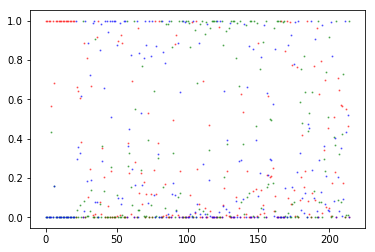

group_sc_A_tilda
 1  2  3 
81 73 61 


   pvalue 
0.2556733 


@@@@@@


group_sc_emb
  1   2   3 
 15  30 170 


   pvalue 
0.4337162 


@@@@@@@@@@@@
###############################################
Epoch: 2001 train_loss= 5.16874 recon_loss= 5.17095 fair_attention_loss= -1.09694 ortho_L_loss= 3.55456 clustering_loss= 14.55754 L1_on_view_hat= 0.00193 L1_on_layer_1= 1.22236


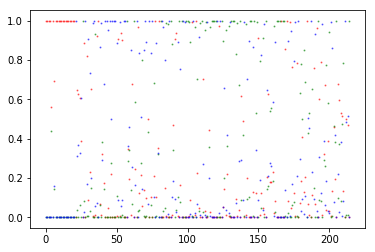

group_sc_A_tilda
 1  2  3 
80 72 63 


   pvalue 
0.4318101 


@@@@@@


group_sc_emb
  1   2   3 
 15 169  31 


   pvalue 
0.2051641 


@@@@@@@@@@@@
###############################################
Epoch: 2101 train_loss= 5.16370 recon_loss= 5.16523 fair_attention_loss= -1.09534 ortho_L_loss= 3.55456 clustering_loss= 14.61895 L1_on_view_hat= 0.00194 L1_on_layer_1= 1.29535


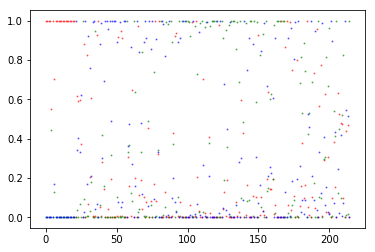

group_sc_A_tilda
 1  2  3 
89 64 62 


   pvalue 
0.9846387 


@@@@@@


group_sc_emb
  1   2   3 
 17  35 163 


  pvalue 
0.256213 


@@@@@@@@@@@@
###############################################
Epoch: 2201 train_loss= 5.15891 recon_loss= 5.15980 fair_attention_loss= -1.09344 ortho_L_loss= 3.55456 clustering_loss= 14.66200 L1_on_view_hat= 0.00195 L1_on_layer_1= 1.36901


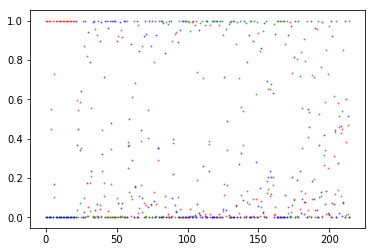

group_sc_A_tilda
 1  2  3 
86 65 64 


  pvalue 
0.737168 


@@@@@@


group_sc_emb
  1   2   3 
163  17  35 


  pvalue 
0.256213 


@@@@@@@@@@@@
###############################################
Epoch: 2301 train_loss= 5.15434 recon_loss= 5.15461 fair_attention_loss= -1.09135 ortho_L_loss= 3.55456 clustering_loss= 14.71703 L1_on_view_hat= 0.00197 L1_on_layer_1= 1.43920


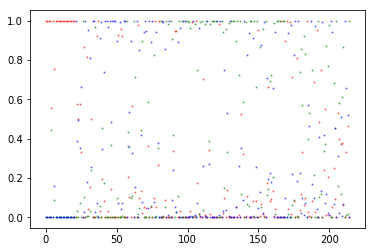

group_sc_A_tilda
 1  2  3 
72 72 71 


   pvalue 
0.5639961 


@@@@@@


group_sc_emb
  1   2   3 
 35 163  17 


   pvalue 
0.5943082 


@@@@@@@@@@@@
###############################################
Epoch: 2401 train_loss= 5.14962 recon_loss= 5.14925 fair_attention_loss= -1.08961 ortho_L_loss= 3.55456 clustering_loss= 14.77852 L1_on_view_hat= 0.00198 L1_on_layer_1= 1.49884


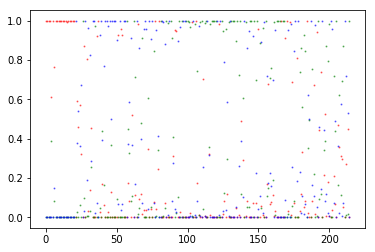

group_sc_A_tilda
 1  2  3 
81 66 68 


   pvalue 
0.3854948 


@@@@@@


group_sc_emb
  1   2   3 
 34  18 163 


   pvalue 
0.6126599 


@@@@@@@@@@@@
###############################################
Epoch: 2501 train_loss= 5.14181 recon_loss= 5.14077 fair_attention_loss= -1.08813 ortho_L_loss= 3.55456 clustering_loss= 14.99953 L1_on_view_hat= 0.00200 L1_on_layer_1= 1.54795


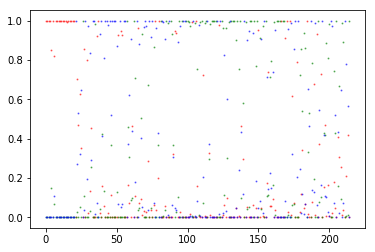

group_sc_A_tilda
 1  2  3 
91 55 69 


   pvalue 
0.7735143 


@@@@@@


group_sc_emb
  1   2   3 
 36 159  20 


  pvalue 
0.685068 


@@@@@@@@@@@@
###############################################
Epoch: 2601 train_loss= 5.13710 recon_loss= 5.13557 fair_attention_loss= -1.08909 ortho_L_loss= 3.55456 clustering_loss= 15.02439 L1_on_view_hat= 0.00200 L1_on_layer_1= 1.59556


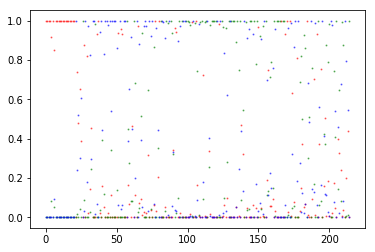

group_sc_A_tilda
 1  2  3 
93 58 64 


   pvalue 
0.3458734 


@@@@@@


group_sc_emb
  1   2   3 
 37 159  19 


   pvalue 
0.5063243 


@@@@@@@@@@@@
###############################################
Epoch: 2701 train_loss= 5.13286 recon_loss= 5.13081 fair_attention_loss= -1.08842 ortho_L_loss= 3.55456 clustering_loss= 15.04969 L1_on_view_hat= 0.00201 L1_on_layer_1= 1.64948


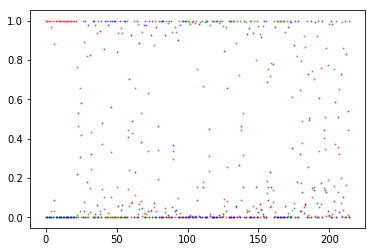

group_sc_A_tilda
 1  2  3 
78 58 79 


    pvalue 
0.01561509 


@@@@@@


group_sc_emb
  1   2   3 
 20 154  41 


   pvalue 
0.5805854 


@@@@@@@@@@@@
###############################################
Epoch: 2801 train_loss= 5.12846 recon_loss= 5.12586 fair_attention_loss= -1.08639 ortho_L_loss= 3.55456 clustering_loss= 15.08240 L1_on_view_hat= 0.00203 L1_on_layer_1= 1.71794


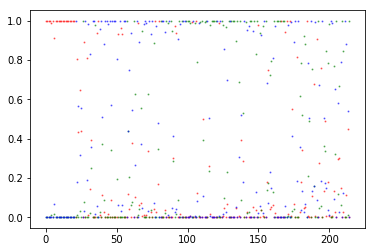

group_sc_A_tilda
 1  2  3 
84 65 66 


   pvalue 
0.1745404 


@@@@@@


group_sc_emb
  1   2   3 
 40  20 155 


   pvalue 
0.5168922 


@@@@@@@@@@@@
###############################################
Epoch: 2901 train_loss= 5.12434 recon_loss= 5.12115 fair_attention_loss= -1.08371 ortho_L_loss= 3.55456 clustering_loss= 15.10981 L1_on_view_hat= 0.00205 L1_on_layer_1= 1.79023


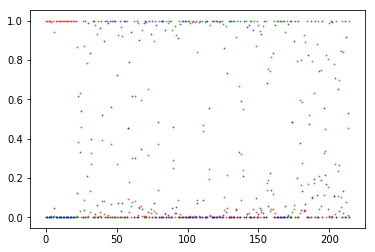

group_sc_A_tilda
 1  2  3 
82 66 67 


   pvalue 
0.9543161 


@@@@@@


group_sc_emb
  1   2   3 
 40  20 155 


   pvalue 
0.5168922 


@@@@@@@@@@@@
###############################################
Epoch: 3001 train_loss= 5.12043 recon_loss= 5.11662 fair_attention_loss= -1.08101 ortho_L_loss= 3.55456 clustering_loss= 15.13058 L1_on_view_hat= 0.00206 L1_on_layer_1= 1.86347


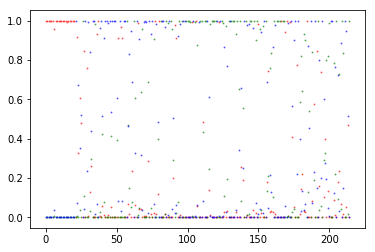

group_sc_A_tilda
 1  2  3 
75 72 68 


   pvalue 
0.4699174 


@@@@@@


group_sc_emb
  1   2   3 
155  20  40 


   pvalue 
0.5168922 


@@@@@@@@@@@@
###############################################
Epoch: 3101 train_loss= 5.11662 recon_loss= 5.11220 fair_attention_loss= -1.07815 ortho_L_loss= 3.55456 clustering_loss= 15.14833 L1_on_view_hat= 0.00208 L1_on_layer_1= 1.93855


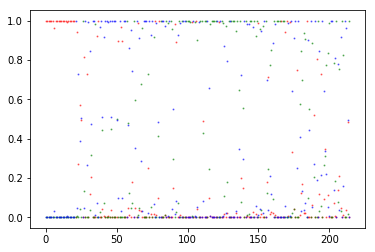

group_sc_A_tilda
 1  2  3 
82 63 70 


   pvalue 
0.4897729 


@@@@@@


group_sc_emb
  1   2   3 
 20  40 155 


   pvalue 
0.5168922 


@@@@@@@@@@@@
###############################################
Epoch: 3201 train_loss= 5.11267 recon_loss= 5.10760 fair_attention_loss= -1.07432 ortho_L_loss= 3.55456 clustering_loss= 15.14445 L1_on_view_hat= 0.00210 L1_on_layer_1= 2.02052


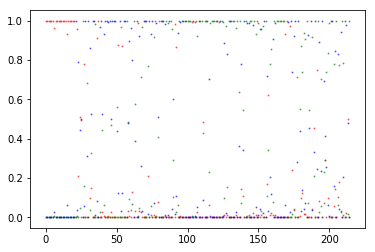

group_sc_A_tilda
 1  2  3 
76 69 70 


   pvalue 
0.4658893 


@@@@@@


group_sc_emb
  1   2   3 
 20  40 155 


   pvalue 
0.5168922 


@@@@@@@@@@@@
###############################################
Epoch: 3301 train_loss= 5.10867 recon_loss= 5.10296 fair_attention_loss= -1.07123 ortho_L_loss= 3.55456 clustering_loss= 15.10380 L1_on_view_hat= 0.00211 L1_on_layer_1= 2.09880


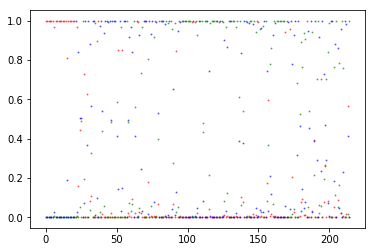

group_sc_A_tilda
 1  2  3 
74 72 69 


   pvalue 
0.3839599 


@@@@@@


group_sc_emb
  1   2   3 
 20  40 155 


   pvalue 
0.5985386 


@@@@@@@@@@@@
###############################################
Epoch: 3401 train_loss= 5.10465 recon_loss= 5.09826 fair_attention_loss= -1.06733 ortho_L_loss= 3.55456 clustering_loss= 15.03243 L1_on_view_hat= 0.00212 L1_on_layer_1= 2.17804


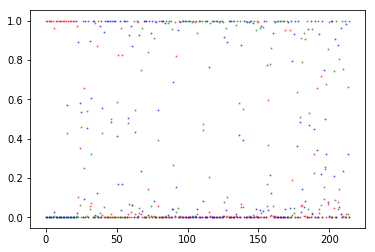

group_sc_A_tilda
 1  2  3 
71 74 70 


   pvalue 
0.5492648 


@@@@@@


group_sc_emb
  1   2   3 
 20  41 154 


   pvalue 
0.6968708 


@@@@@@@@@@@@
###############################################
Epoch: 3501 train_loss= 5.10047 recon_loss= 5.09334 fair_attention_loss= -1.06180 ortho_L_loss= 3.55456 clustering_loss= 15.08745 L1_on_view_hat= 0.00214 L1_on_layer_1= 2.26496


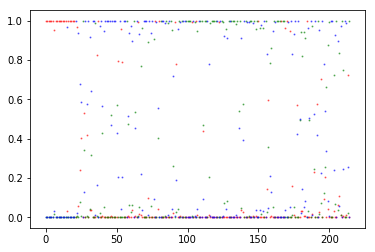

group_sc_A_tilda
 1  2  3 
77 69 69 


   pvalue 
0.2229779 


@@@@@@


group_sc_emb
  1   2   3 
160  34  21 


   pvalue 
0.3366465 


@@@@@@@@@@@@
###############################################
Epoch: 3601 train_loss= 5.09610 recon_loss= 5.08815 fair_attention_loss= -1.05555 ortho_L_loss= 3.55456 clustering_loss= 15.09669 L1_on_view_hat= 0.00216 L1_on_layer_1= 2.36731


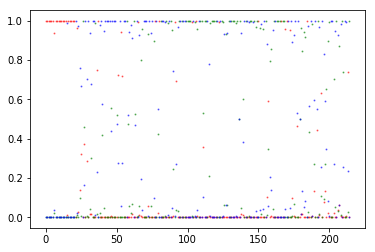

group_sc_A_tilda
 1  2  3 
86 67 62 


   pvalue 
0.2187157 


@@@@@@


group_sc_emb
  1   2   3 
 21 160  34 


   pvalue 
0.3366465 


@@@@@@@@@@@@
###############################################
Epoch: 3701 train_loss= 5.09164 recon_loss= 5.08284 fair_attention_loss= -1.04857 ortho_L_loss= 3.55456 clustering_loss= 15.11938 L1_on_view_hat= 0.00218 L1_on_layer_1= 2.48012


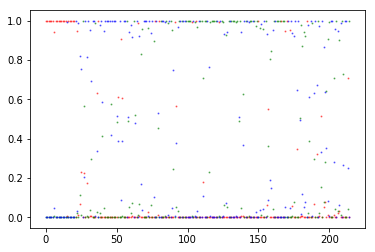

group_sc_A_tilda
 1  2  3 
81 65 69 


   pvalue 
0.9954428 


@@@@@@


group_sc_emb
  1   2   3 
155  22  38 


   pvalue 
0.4696357 


@@@@@@@@@@@@
###############################################
Epoch: 3801 train_loss= 5.08663 recon_loss= 5.07688 fair_attention_loss= -1.04046 ortho_L_loss= 3.55456 clustering_loss= 15.16701 L1_on_view_hat= 0.00221 L1_on_layer_1= 2.59177


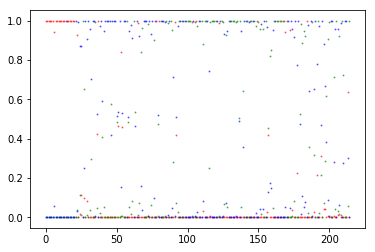

group_sc_A_tilda
 1  2  3 
84 56 75 


   pvalue 
0.5810842 


@@@@@@


group_sc_emb
  1   2   3 
156  38  21 


   pvalue 
0.3958576 


@@@@@@@@@@@@
###############################################
Epoch: 3901 train_loss= 5.08195 recon_loss= 5.07133 fair_attention_loss= -1.03838 ortho_L_loss= 3.55456 clustering_loss= 15.20228 L1_on_view_hat= 0.00222 L1_on_layer_1= 2.69546


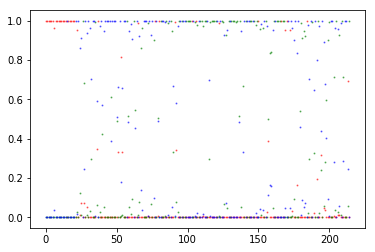

group_sc_A_tilda
 1  2  3 
85 63 67 


   pvalue 
0.9216243 


@@@@@@


group_sc_emb
  1   2   3 
 39 154  22 


   pvalue 
0.5536911 


@@@@@@@@@@@@
###############################################

 ######################################################### 



In [127]:
#Training Cell  LBFGS
#optimzier_type = 'lbfgs'
optimzier_type = 'adam'

my_model = Model(optimzier_type,torch.Tensor(get_nomralized_laplacian(W_gene)),torch.Tensor(get_nomralized_laplacian(W_methy)),torch.Tensor(get_nomralized_laplacian(W_mirna)))

train_features_tensor = torch.Tensor(np.identity(215))

for epoch_counter in range(4000):

  
  
  
  if optimzier_type=='lbfgs':
    my_model.backprop2(train_features_tensor)
  elif optimzier_type=='adam':
    my_model.forward(train_features_tensor)
    my_model.backprop()

  if epoch_counter % 100 ==0:
      loss,recon_loss,fair_attention_loss,ortho_L_loss,clustering_loss,L1_on_view_hat,L1_on_layer_1 = my_model.forward(train_features_tensor)
      print("Epoch:", '%04d' % (epoch_counter + 1), "train_loss=", "{:.5f}".format(loss), "recon_loss=", "{:.5f}".format(recon_loss), "fair_attention_loss=", "{:.5f}".format(fair_attention_loss), "ortho_L_loss=", "{:.5f}".format(ortho_L_loss), "clustering_loss=", "{:.5f}".format(clustering_loss), "L1_on_view_hat=", "{:.5f}".format(L1_on_view_hat), "L1_on_layer_1=", "{:.5f}".format(L1_on_layer_1))
      plt.scatter(x=range(215), y=torch.Tensor(my_model.g_gene).detach().numpy(), s=1, c= 'red', alpha=0.5)
      plt.scatter(x=range(215), y=torch.Tensor(my_model.g_methy).detach().numpy(), s=1, c= 'green', alpha=0.5)
      plt.scatter(x=range(215), y=torch.Tensor(my_model.g_mirna).detach().numpy(), s=1, c= 'blue', alpha=0.5)
      plt.show()
      
      A_tilda = torch.Tensor(my_model.view_hat).detach().numpy()
      A_tilda_intermediate = ro.r.matrix(A_tilda, nrow=A_tilda.shape[0], ncol=A_tilda.shape[1])
      ro.r.assign("A_tilda", A_tilda_intermediate)
      %R group_sc_A_tilda <- NL_spectralClustering(A_tilda, K=3, type = 3) 
      %R print(table(group_sc_A_tilda))
      %R print(get_cox_pvalue(group_sc_A_tilda)[[9]][3])
      print("@@@@@@")
      emb = torch.Tensor(my_model.layer_1).detach().numpy()
      emb_intermediate = ro.r.matrix(emb, nrow=emb.shape[0], ncol=emb.shape[1])
      ro.r.assign("emb", emb_intermediate)
      %R group_sc_emb <- kmeans(emb, 3, nstart = 25)$cluster 
      %R print(table(group_sc_emb))
      %R print(get_cox_pvalue(group_sc_emb)[[9]][3])
      print("@@@@@@@@@@@@")
      # %R Dist_emb = dist2(as.matrix(emb),as.matrix(emb))
      # %R W_emb = custom_affinity_matrix(Dist_emb, K=20, 1300)
      # %R group_sc_W_emb = spectralClustering(W_emb,3, type = 3)
      # %R print(table(group_sc_W_emb))
      # %R print(get_cox_pvalue(group_sc_W_emb)[[9]][3])
      print("###############################################")


print('\n',"#########################################################",'\n')






Epoch: 4000 train_loss= 5.12975 recon_loss= 5.13220 fair_attention_loss= -1.05939 ortho_L_loss= 3.40175 clustering_loss= 15.58009 L1_on_view_hat= 0.00221 L1_on_layer_1= 1.81246


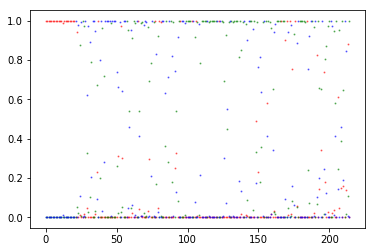

group_sc_A_tilda
 1  2  3 
89 66 60 


   pvalue 
0.9479336 


@@@@@@


group_sc_emb
  1   2   3 
 30 142  43 


   pvalue 
0.8072831 


In [107]:
my_model.dropout_layer_1.eval()
my_model.dropout_layer_1.eval()
loss,recon_loss,fair_attention_loss,ortho_L_loss,clustering_loss,L1_on_view_hat,L1_on_layer_1 = my_model.forward(train_features_tensor)
print("Epoch:", '%04d' % (epoch_counter + 1), "train_loss=", "{:.5f}".format(loss), "recon_loss=", "{:.5f}".format(recon_loss), "fair_attention_loss=", "{:.5f}".format(fair_attention_loss), "ortho_L_loss=", "{:.5f}".format(ortho_L_loss), "clustering_loss=", "{:.5f}".format(clustering_loss), "L1_on_view_hat=", "{:.5f}".format(L1_on_view_hat), "L1_on_layer_1=", "{:.5f}".format(L1_on_layer_1))
plt.scatter(x=range(215), y=torch.Tensor(my_model.g_gene).detach().numpy(), s=1, c= 'red', alpha=0.5)
plt.scatter(x=range(215), y=torch.Tensor(my_model.g_methy).detach().numpy(), s=1, c= 'green', alpha=0.5)
plt.scatter(x=range(215), y=torch.Tensor(my_model.g_mirna).detach().numpy(), s=1, c= 'blue', alpha=0.5)
plt.show()
      
A_tilda = torch.Tensor(my_model.view_hat).detach().numpy()
A_tilda_intermediate = ro.r.matrix(A_tilda, nrow=A_tilda.shape[0], ncol=A_tilda.shape[1])
ro.r.assign("A_tilda", A_tilda_intermediate)
%R group_sc_A_tilda <- NL_spectralClustering(A_tilda, K=3, type = 3) 
%R print(table(group_sc_A_tilda))
%R print(get_cox_pvalue(group_sc_A_tilda)[[9]][3])
print("@@@@@@")
emb = torch.Tensor(my_model.layer_1).detach().numpy()
emb_intermediate = ro.r.matrix(emb, nrow=emb.shape[0], ncol=emb.shape[1])
ro.r.assign("emb", emb_intermediate)
%R group_sc_emb <- kmeans(emb, 3, nstart = 25)$cluster 
%R print(table(group_sc_emb))
%R print(get_cox_pvalue(group_sc_emb)[[9]][3])

In [0]:
#my_model.forward(train_features_tensor)
#print((torch.abs(my_model.x_prim-train_features_tensor)).sum(1).mean(0))
print(my_model.layer_1.shape)
print(my_model.layer_2.shape)
print(my_model.layer_2[0:7,0:7])
print(torch.abs(my_model.x_prim-train_features_tensor).sum(1).mean(0))

torch.Size([215, 10])
torch.Size([215, 215])
tensor([[9.9985e-01, 8.2313e-06, 3.4610e-15, 8.6199e-06, 1.7631e-07, 0.0000e+00,
         5.3301e-32],
        [2.6683e-05, 9.9976e-01, 2.4150e-13, 1.0792e-04, 3.2480e-08, 0.0000e+00,
         4.4461e-20],
        [5.6396e-20, 1.8818e-25, 9.9993e-01, 9.9341e-08, 2.0671e-07, 3.9182e-35,
         2.6782e-07],
        [3.5054e-05, 2.1020e-04, 8.0365e-08, 9.9860e-01, 1.2415e-04, 0.0000e+00,
         6.0303e-15],
        [1.5615e-08, 9.8857e-11, 1.1805e-05, 3.9773e-05, 9.9986e-01, 1.3149e-39,
         1.5278e-14],
        [5.1710e-17, 1.5841e-23, 4.0194e-12, 1.2740e-13, 5.1746e-13, 9.9958e-01,
         6.5252e-22],
        [1.5537e-09, 2.0073e-08, 8.9693e-07, 8.5286e-08, 1.0689e-07, 2.4470e-20,
         9.9964e-01]], grad_fn=<SliceBackward>)
tensor(0.9495, grad_fn=<MeanBackward2>)


In [0]:
%R cluster_num <-9
%R group_sc_emb <- kmeans(emb, cluster_num, nstart = 25)$cluster 
%R print(table(group_sc_emb))
%R print(get_cox_pvalue(group_sc_emb)[[9]][3])
%R group_sc_A_tilda <- NL_spectralClustering(A_tilda, cluster_num, type = 3) 
%R print(table(group_sc_A_tilda))
%R print(get_cox_pvalue(group_sc_A_tilda)[[9]][3])

group_sc_emb
 1  2  3  4  5  6  7  8  9 
15 16 17 18 22 20 10 45 52 


   pvalue 
0.2927874 


group_sc_A_tilda
 1  2  3  4  5  6  7  8  9 
63  8 33 14 17 30 19 20 11 


   pvalue 
0.3737221 


In [0]:
my_model.forward(train_features_tensor)
#print(my_model.x_prim)

permutation = np.arange(215)
np.random.shuffle(permutation)
permuted_i = np.zeros((215,215))
for i in range(215):
  permuted_i[i,permutation[i]]=1
permuted_i_tensor = torch.Tensor(permuted_i)
my_model.forward(permuted_i_tensor)
permuted_i_response_tensor = my_model.layer_2

compare_tensor = (np.c_[torch.nonzero(permuted_i_tensor)[:,1].numpy(),permuted_i_response_tensor.argmax(1).numpy()])
print(np.abs(compare_tensor[:,0]-compare_tensor[:,1]).sum())
#print()

12580


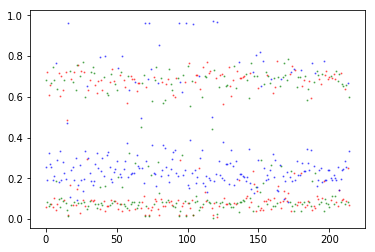

In [0]:
#print(my_model.g_gene)
#print(my_model.g_mirna)
plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 'red', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 'green', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 'blue', alpha=0.5)

#print(my_model.A_tilda_gene)
#print(W_gene[range(215),range(215)])
#print(W_methy[range(215),range(215)])
#print(W_mirna[range(215),range(215)])

#print(my_model.A_tilda_gene)
#ordx = np.argsort(my_model.g_gene.detach().numpy())
#ordxx = ordx[0:150]
#ordxxx = ordx[150:215]
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy()[ordx], s=1, c= 0.1*np.ones(215), alpha=0.5)
#print(np.c_[my_model.g_gene.detach().numpy()[ordx],np.array(range(215))])
#print(truelabel[:,1][ordxx].mean())
#print(truelabel[:,1][ordxxx].mean())
#print()
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 0.4*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 0.9*np.ones(215), alpha=0.5)
plt.show()


In [0]:

#np.savetxt("/content/drive/My Drive/Data Fusion/results/W_v51.txt",my_model.A_tilda_hat.detach().numpy(),delimiter='\t')
#np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v50.txt",my_model.embedding.detach().numpy(),delimiter='\t')
#print(my_model.A_tilda_hat.detach().numpy())

In [0]:
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v21.txt",emb,delimiter='\t')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
print(W_gene[0:5,0:5])

[[2.20250988e-05 1.23456250e-05 7.98397838e-06 8.33432746e-06
  8.13768903e-06]
 [1.23456250e-05 2.79446012e-05 5.99251221e-06 1.14434393e-05
  8.52149002e-06]
 [7.98397838e-06 5.99251221e-06 1.60516449e-05 6.20174722e-06
  7.64236148e-06]
 [8.33432746e-06 1.14434393e-05 6.20174722e-06 2.16228805e-05
  7.77526885e-06]
 [8.13768903e-06 8.52149002e-06 7.64236148e-06 7.77526885e-06
  1.99531018e-05]]


In [0]:
%%R
print(W_gene[0:5,0:5])
print(W_methy[0:5,0:5])
print(W_mirna[0:5,0:5])
r.
#print(Dist_gene[0:5,0:5])


              V2            V3            V4            V5            V6
V2  3.068787e-04  3.187392e-51 7.611139e-122 3.026863e-112 1.089196e-117
V3  3.187392e-51  3.068787e-04 4.930383e-199  2.041452e-60 5.391200e-107
V4 7.611139e-122 4.930383e-199  3.068787e-04 8.882017e-195 1.315769e-132
V5 3.026863e-112  2.041452e-60 8.882017e-195  3.068787e-04 4.503802e-128
V6 1.089196e-117 5.391200e-107 1.315769e-132 4.503802e-128  3.068787e-04
             V2           V3           V4           V5           V6
V2 3.068787e-04 1.232209e-04 5.839313e-05 1.308644e-04 7.176845e-05
V3 1.232209e-04 3.068787e-04 6.562024e-05 1.043658e-04 4.488297e-05
V4 5.839313e-05 6.562024e-05 3.068787e-04 1.055716e-04 1.602596e-05
V5 1.308644e-04 1.043658e-04 1.055716e-04 3.068787e-04 4.092852e-05
V6 7.176845e-05 4.488297e-05 1.602596e-05 4.092852e-05 3.068787e-04
             V2           V3           V4           V5           V6
V2 0.0003068787 0.0002558803 0.0002380599 0.0002286589 0.0002155245
V3 0.0002558803 0.

In [0]:
print(np.array(ro.r['W_gene']).shape)

(215, 215)


In [0]:
%%R

	

# install.packages("SNFtool")
# install.packages("data.table")
# install.packages("survival")
# install.packages("survminer")
# install.packages("mltools")

#install.packages("dplyr")
#install.packages("pheatmap")
#install.packages("factoextra")
#install.packages("gplots")
#library(gplots)
#install.packages("ggplot2")


library(SNFtool)
library(data.table)
library(survival)
library(survminer)
library(mltools)
# library(dplyr)
# library(pheatmap)
# library(factoextra)
# library(ggplot2)









In [0]:
%%R
NL_spectralClustering <- function (NL, K, type = 3) 
{
	eig <- eigen(NL)
	res <- sort(abs(eig$values), index.return = TRUE)
	U <- eig$vectors[, res$ix[1:K]]
	normalize <- function(x) x/sqrt(sum(x^2))
	if (type == 3) {
		U <- t(apply(U, 1, normalize))
	}     
	
	eigDiscrete <- SNFtool:::.discretisation(U)
	eigDiscrete <- eigDiscrete$discrete
	labels <- apply(eigDiscrete, 1, which.max)
	return(labels)
}

get_cox_pvalue<-function(group){
  one_hot_group <- matrix(0, 215, max(group))
  for (i in 1:215){
    one_hot_group[i,group[i]]<-1
  }
  tt<-coxph(Surv( survival,censor ) ~ one_hot_group)
  return(summary(tt))
}

get_cox_pvalue2<-function(group){
  tt<-coxph(Surv( survival,censor ) ~ group)
  return(summary(tt))
}

custom_affinity_matrix <- function (diff, K = 20, sigma = 0.5) 
{
	N <- nrow(diff)
	diff <- (diff + t(diff))/2
	diag(diff) <- 0
	sortedColumns <- as.matrix(t(apply(diff, 2, sort)))
	finiteMean <- function(x) {
		return(mean(x[is.finite(x)]))
	}
	means <- apply(sortedColumns[, 1:K + 1], 1, finiteMean) + 
		.Machine$double.eps
	avg <- function(x, y) {
		return((x + y)/2)
	}
	Sig <- outer(means, means, avg)/3 * 2 + diff/3 + .Machine$double.eps
	Sig[Sig <= .Machine$double.eps] <- .Machine$double.eps
	#print(Sig)
  Sig <- matrix(1, 215, 215)
  densities <- dnorm(diff, 0, sigma * Sig, log = FALSE)
	W <- (densities + t(densities))/2
	return(W)
}

In [7]:

import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()


survival_intermediate = ro.r.matrix(truelabel[:,1], nrow=215, ncol=1)
ro.r.assign("survival", survival_intermediate)

censor_intermediate = ro.r.matrix(truelabel[:,2], nrow=215, ncol=1)
ro.r.assign("censor", censor_intermediate)

%R survival <- as.numeric(survival)
%R censor <- as.numeric(censor)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
%%R

##40 ,3 
###20 0.6
####30 0.3
K = 20;##number of neighbors, usually (10~30)
alpha = 1500 ##hyperparameter, usually (0.3~0.8)
T = 17; ###Number of Iterations, usually (10~20)
C = 3###number of clusters
use.corr <- F


gene <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", header = F, sep = "\t", dec = ".")[,2:216])
methy <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", header = F, sep = "\t", dec = ".")[,2:216])
mirna <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", header = F, sep = "\t", dec = ".")[,2:216])
survival <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", header = F, sep = "\t", dec = ".")[-1,2])
censor <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", header = F, sep = "\t", dec = ".")[-1,3])



gene = t(gene)
methy = t(methy)
mirna = t(mirna)


methy = standardNormalization(methy);
gene = standardNormalization(gene);
mirna = standardNormalization(mirna);

Dist_methy = dist2(as.matrix(methy),as.matrix(methy));
Dist_gene = dist2(as.matrix(gene),as.matrix(gene));
Dist_mirna = dist2(as.matrix(mirna),as.matrix(mirna));

W_methy = custom_affinity_matrix(Dist_methy, K, 1000)
W_gene = custom_affinity_matrix(Dist_gene, K, 10000)
W_mirna = custom_affinity_matrix(Dist_mirna, K, 400)




In [9]:
#%%R
#W_gene[0:5,0:5]
#W_mirna[0:5,0:5]
#W_methy[0:5,0:5]

print(my_model.W0.weight.shape)

NameError: ignored